In [1]:
import pandas as pd

# Load the datasets
edges_df = pd.read_csv('topic4_edge_list_10000_customers.csv')
nodes_df = pd.read_csv('topic4_node_list_10000_customers.csv')

import networkx as nx

# Initialize the graph
G = nx.Graph()

# Add movie and customer nodes
G.add_nodes_from(nodes_df[nodes_df['Type'] == 'Movie']['ID'], bipartite=1)
G.add_nodes_from(nodes_df[nodes_df['Type'] == 'Customer']['ID'], bipartite=0)

# Add edges with weights (ratings)
for _, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# This will create a dictionary with movies as keys and their weighted degree as values
movie_degrees = {node: val for node, val in G.degree(weight='weight') if isinstance(node, str) and node.startswith('M')}

# Sort the movies based on the weighted degree
sorted_movies = sorted(movie_degrees.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 influential movies
top_10_movies = sorted_movies[:10]
for movie, degree in top_10_movies:
    print(f"Movie ID: {movie}, Weighted Degree: {degree}")


Movie ID: M1905, Weighted Degree: 17280
Movie ID: M2452, Weighted Degree: 14262
Movie ID: M4306, Weighted Degree: 14249
Movie ID: M3938, Weighted Degree: 13399
Movie ID: M3962, Weighted Degree: 13217
Movie ID: M571, Weighted Degree: 13156
Movie ID: M4432, Weighted Degree: 12655
Movie ID: M2782, Weighted Degree: 12514
Movie ID: M2862, Weighted Degree: 11921
Movie ID: M3624, Weighted Degree: 11887


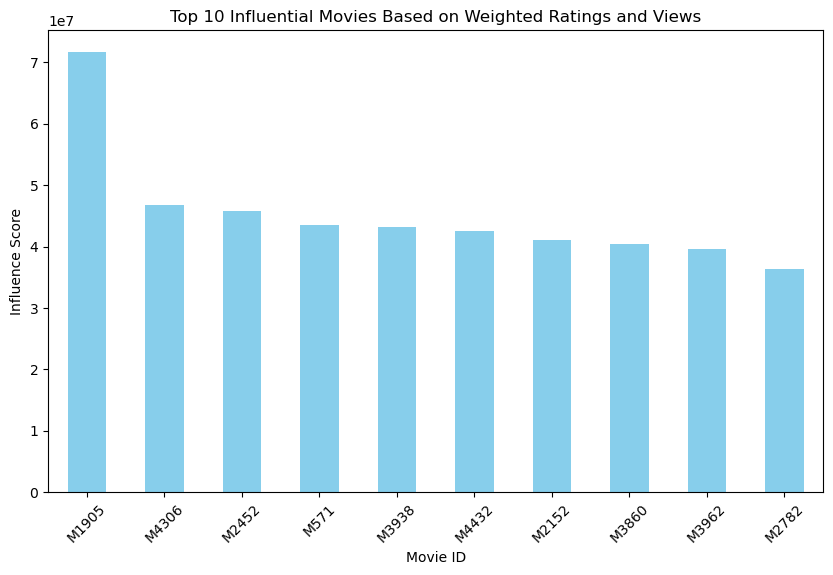

In [2]:
import pandas as pd

# Load the datasets
edges_df = pd.read_csv('topic4_edge_list_10000_customers.csv')

# Calculate the weighted sum of ratings and views for each movie
# First, multiply the rating (weight) by the number of views for each movie
edges_df['weighted_rating'] = edges_df['Weight']

# Group by movie and sum up the weighted ratings
movie_influence = edges_df.groupby('Target')['weighted_rating'].sum()

# Now, to get the views per movie, we simply count the number of occurrences of each movie in the edges dataset
movie_views = edges_df['Target'].value_counts()

# Combine both views and weighted ratings into a single DataFrame
movie_influence_df = pd.DataFrame({
    'views': movie_views,
    'total_weighted_rating': movie_influence
})

# Calculate the final influence score by multiplying the views by the average rating for each movie
movie_influence_df['influence_score'] = movie_influence_df['views'] * movie_influence_df['total_weighted_rating']

# Sort the movies by their influence score
ranked_movies = movie_influence_df.sort_values(by='influence_score', ascending=False)

# Save the DataFrame to a CSV file
ranked_movies.to_csv('influence_scores.csv', index_label='MovieID')

# Display the top 10 influential movies based on the calculated score
ranked_movies.head(10)

import matplotlib.pyplot as plt

# Plotting the top 10 influential movies
top_10_movies = ranked_movies.head(10)
top_10_movies['influence_score'].plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 10 Influential Movies Based on Weighted Ratings and Views')
plt.xlabel('Movie ID')
plt.ylabel('Influence Score')
plt.xticks(rotation=45)
plt.show()

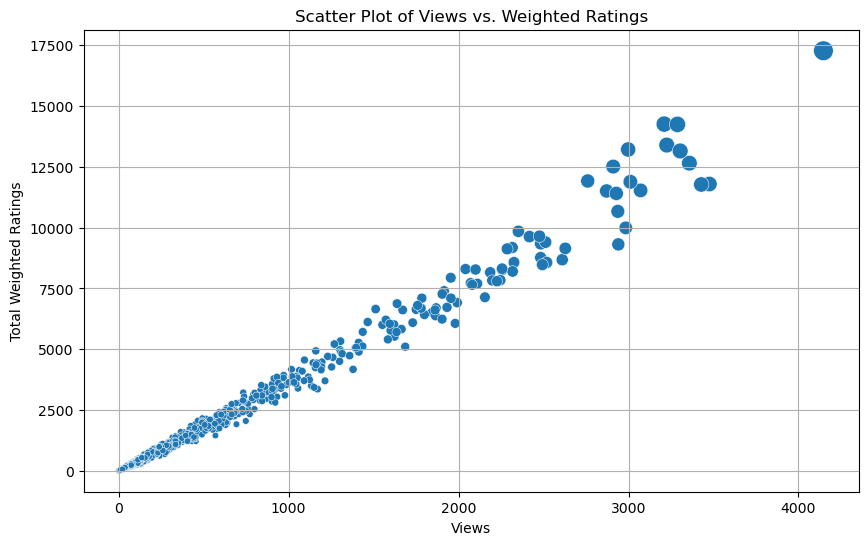

In [3]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=movie_influence_df, x='views', y='total_weighted_rating', size='influence_score', legend=False, sizes=(20, 200))
plt.title('Scatter Plot of Views vs. Weighted Ratings')
plt.xlabel('Views')
plt.ylabel('Total Weighted Ratings')
plt.grid(True)
plt.show()


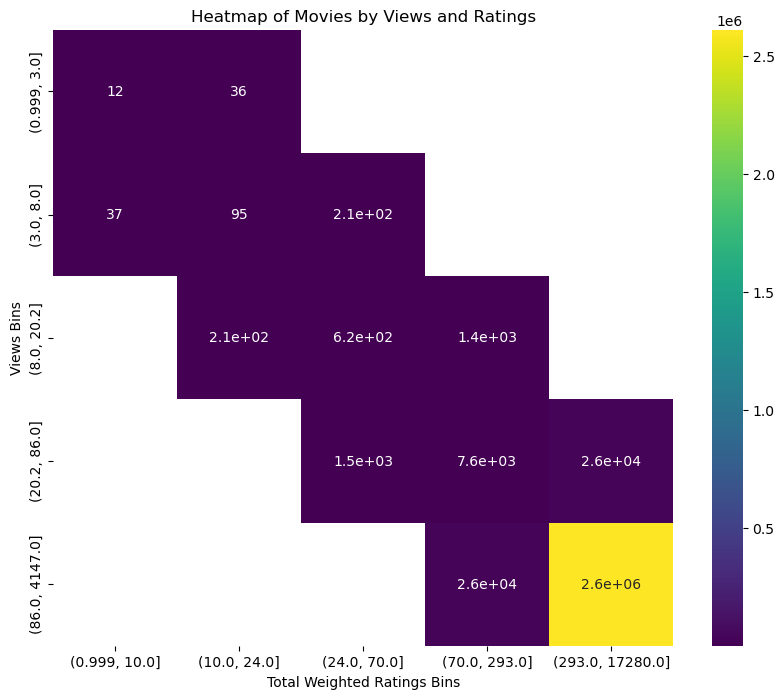

In [4]:
# Binning data for heatmap
movie_influence_df['views_bin'] = pd.qcut(movie_influence_df['views'], 5, duplicates='drop')
movie_influence_df['ratings_bin'] = pd.qcut(movie_influence_df['total_weighted_rating'], 5, duplicates='drop')

# Creating pivot table for heatmap
heatmap_data = movie_influence_df.pivot_table(index='views_bin', columns='ratings_bin', values='influence_score', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True)
plt.title('Heatmap of Movies by Views and Ratings')
plt.xlabel('Total Weighted Ratings Bins')
plt.ylabel('Views Bins')
plt.show()

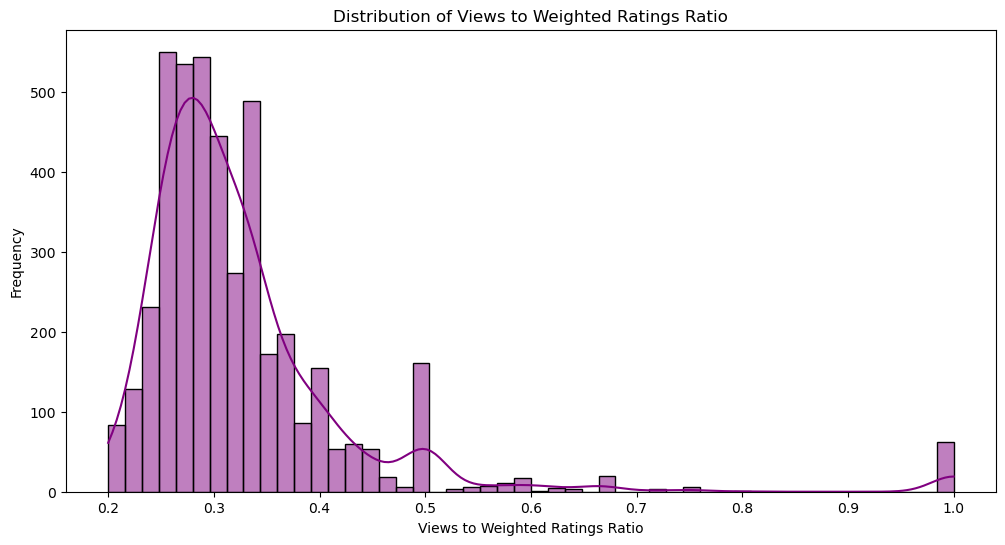

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the movie influence data
movie_influence_df = pd.read_csv('influence_scores.csv')

# Calculate the ratio of views to weighted ratings
movie_influence_df['views_to_weight_ratio'] = movie_influence_df['views'] / movie_influence_df['total_weighted_rating']

# Plotting the distribution of the views to weighted ratings ratio
plt.figure(figsize=(12, 6))
sns.histplot(movie_influence_df['views_to_weight_ratio'], bins=50, kde=True, color='purple')
plt.title('Distribution of Views to Weighted Ratings Ratio')
plt.xlabel('Views to Weighted Ratings Ratio')
plt.ylabel('Frequency')
plt.show()

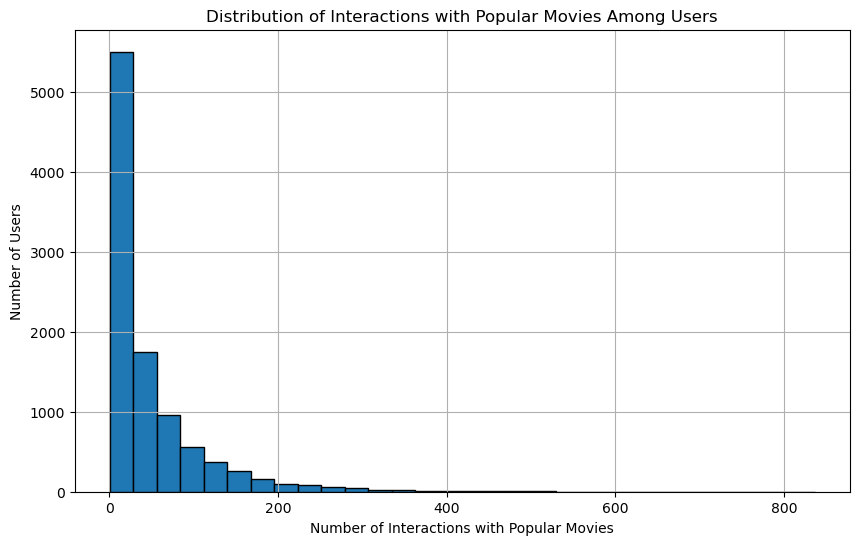

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming influence_scores.csv has already been saved from part a
movie_influence_df = pd.read_csv('influence_scores.csv')

# Define a threshold to identify popular movies
threshold = movie_influence_df['influence_score'].quantile(0.75)
popular_movies = movie_influence_df[movie_influence_df['influence_score'] >= threshold]['MovieID']

# Load the edge dataset to analyze interactions
edges_df = pd.read_csv('topic4_edge_list_10000_customers.csv')

# Filter interactions to only those involving popular movies
popular_interactions = edges_df[edges_df['Target'].isin(popular_movies)]

# Analyze how many users have interacted with popular movies
user_interactions = popular_interactions.groupby('Source').size()

# Plot the distribution of interactions per user
plt.figure(figsize=(10, 6))
user_interactions.hist(bins=30, edgecolor='black')
plt.title('Distribution of Interactions with Popular Movies Among Users')
plt.xlabel('Number of Interactions with Popular Movies')
plt.ylabel('Number of Users')
plt.show()

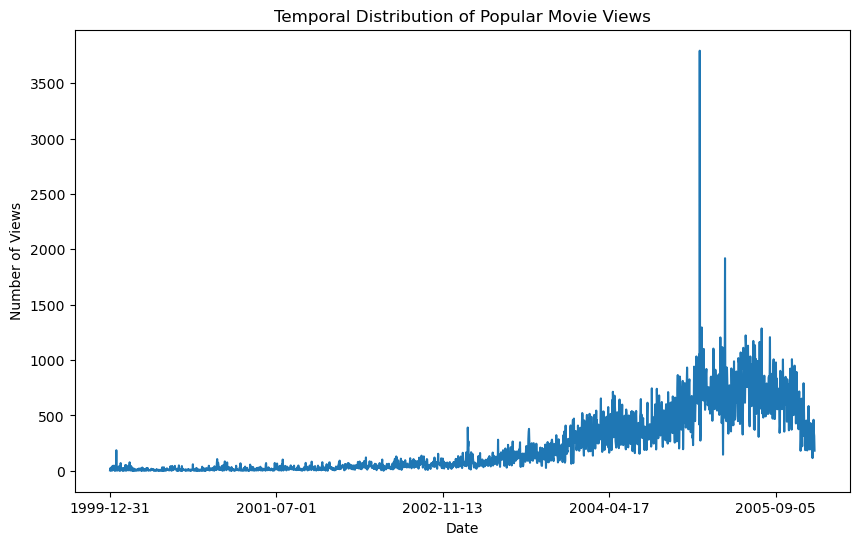

In [7]:
# Optionally, investigate the temporal aspect if dates are available
if 'Date' in edges_df.columns:
    edges_df['Date'] = pd.to_datetime(edges_df['Date'])
    temporal_distribution = popular_interactions.groupby('Date').size()
    plt.figure(figsize=(10, 6))
    temporal_distribution.plot()
    plt.title('Temporal Distribution of Popular Movie Views')
    plt.xlabel('Date')
    plt.ylabel('Number of Views')
    plt.show()

In [8]:
# Importing pandas to handle data processing
import pandas as pd

# Load the edge dataset to analyze interactions
edges_df = pd.read_csv('topic4_edge_list_10000_customers.csv')

# Convert 'Date' column to datetime
edges_df['Date'] = pd.to_datetime(edges_df['Date'])

# Find the date with the peak number of views
peak_date = edges_df.groupby('Date').size().idxmax()

# Filter the interactions for the peak date
peak_day_interactions = edges_df[edges_df['Date'] == peak_date]

# Find the movie with the most interactions on the peak day
top_movie_id_on_peak_day = peak_day_interactions.groupby('Target').size().idxmax()

top_movie_id_on_peak_day

'M2874'